In [1]:
from google.colab import drive
drive.mount('/content/drive')

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**DATA LOADING AND PREPROCESSING**

Número total de valores negativos en CHL: 0
Porcentaje de valores NaN: 38.33%


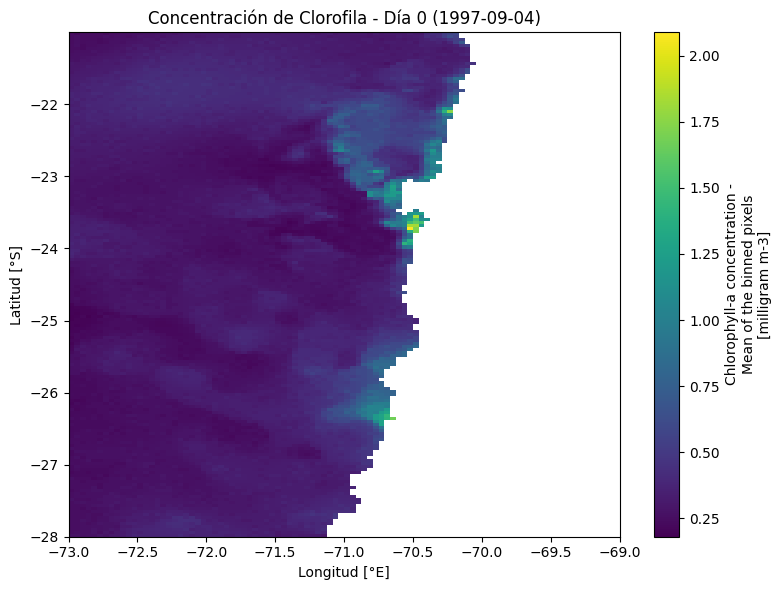

In [2]:
# Carga del primer dataset, correspondiente a los datos de clorofila

ds = xr.open_dataset("drive/MyDrive/chl_cmems_obs-oc_glo_bgc-plankton_my_l4-gapfree-multi-4km_P1D.nc")

# Limite a la región de estudio especificada

lat_min, lat_max = -27.98, -21.02
lon_min, lon_max = -72.98, -69.02
ds = ds.sel(
    latitude=slice(lat_min, lat_max),
    longitude=slice(lon_min, lon_max)
)

# Extracción de variable CHL

chl = ds['CHL']

# Conteo de valores no lógicos (Negativos o NaN)
num_negativos = (chl < 0).sum().item()
print(f"Número total de valores negativos en CHL: {num_negativos}")

num_nans = chl.isnull().sum().item()
total_valores = chl.size
porcentaje_nans = (num_nans / total_valores) * 100
print(f"Porcentaje de valores NaN: {porcentaje_nans:.2f}%")

# Grafica geogrfica del primer día de nuestra serie de tiempo para observar la concentración de CHL

plt.figure(figsize=(8, 6))
chl.isel(time=0).plot(cmap='viridis')
plt.title("Concentración de Clorofila - Día 0 (1997-09-04)")
plt.xlabel("Longitud [°E]")
plt.ylabel("Latitud [°S]")
plt.grid(False)
plt.tight_layout()
plt.show()

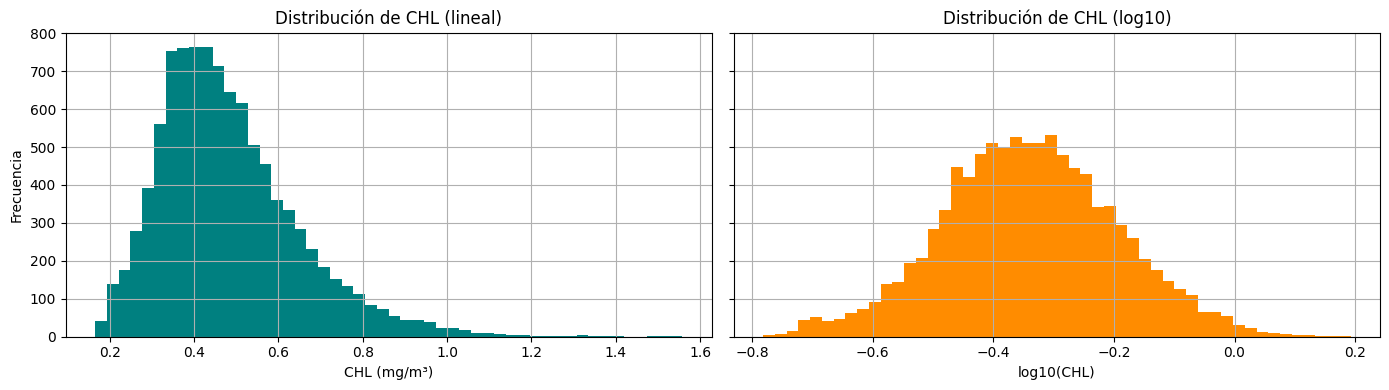

In [3]:
# Extracción y conversión a dataframe de la concentración de CHL por día

chl_media_diaria = chl.mean(dim=["latitude", "longitude"], skipna=True)
chl_media_diaria_df = chl_media_diaria.to_dataframe().reset_index()

# Histograma de la distribución de CHL por día lineal y logaritmica.

chl_vals = chl_media_diaria_df['CHL']
chl_log_vals = np.log10(chl_vals)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4), sharey=True)
ax1.hist(chl_vals, bins=50, color='teal')
ax1.set_title("Distribución de CHL (lineal)")
ax1.set_xlabel("CHL (mg/m³)")
ax1.set_ylabel("Frecuencia")
ax1.grid(True)

ax2.hist(chl_log_vals, bins=50, color='darkorange')
ax2.set_title("Distribución de CHL (log10)")
ax2.set_xlabel("log10(CHL)")
ax2.grid(True)
plt.tight_layout()
plt.show()

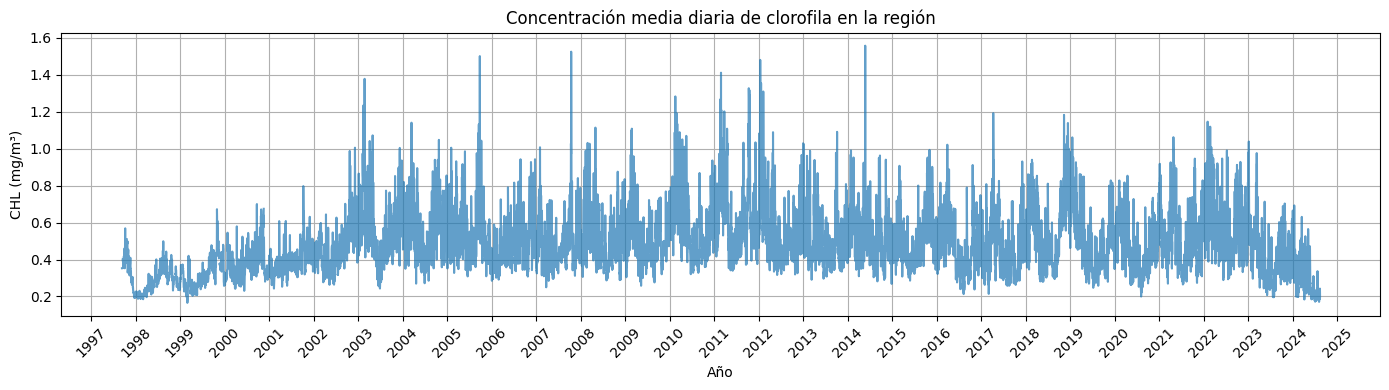

In [4]:
# Observación del comportamiento de CHL a lo largo de los 27 años

plt.figure(figsize=(14, 4))
plt.plot(chl_media_diaria_df['time'], chl_media_diaria_df['CHL'], alpha=0.7)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.title("Concentración media diaria de clorofila en la región")
plt.xlabel("Año")
plt.ylabel("CHL (mg/m³)")
plt.grid(True)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/xarray/groupers.py:487: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


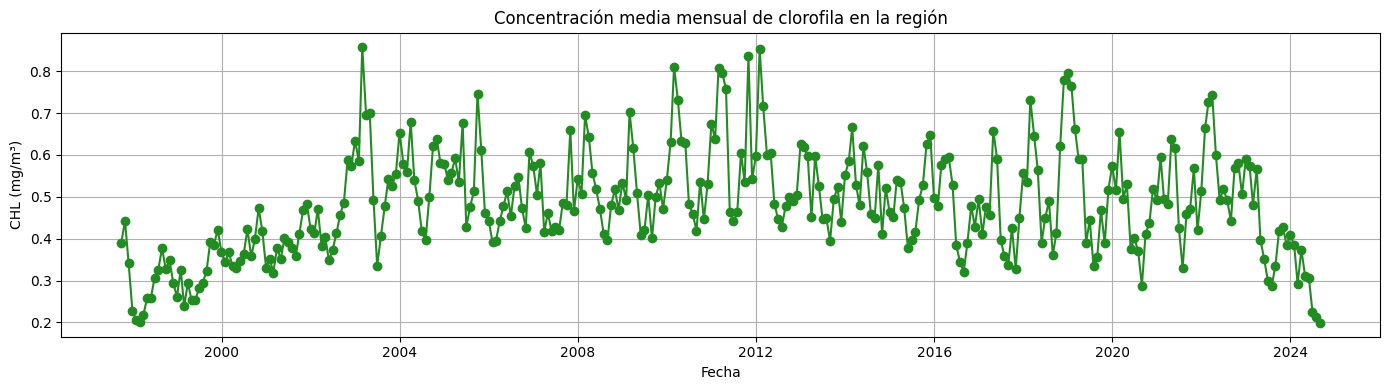

In [5]:
# Observación, de promedio mensual de CHL por 27 años

chl_media_mensual = chl_media_diaria.resample(time="1M").mean()

chl_media_mensual_df = chl_media_mensual.to_dataframe().reset_index()

plt.figure(figsize=(14, 4))
plt.plot(chl_media_mensual_df['time'], chl_media_mensual_df['CHL'], color='forestgreen', marker='o', linestyle='-')
plt.title("Concentración media mensual de clorofila en la región")
plt.xlabel("Fecha")
plt.ylabel("CHL (mg/m³)")
plt.grid(True)
plt.tight_layout()
plt.show()

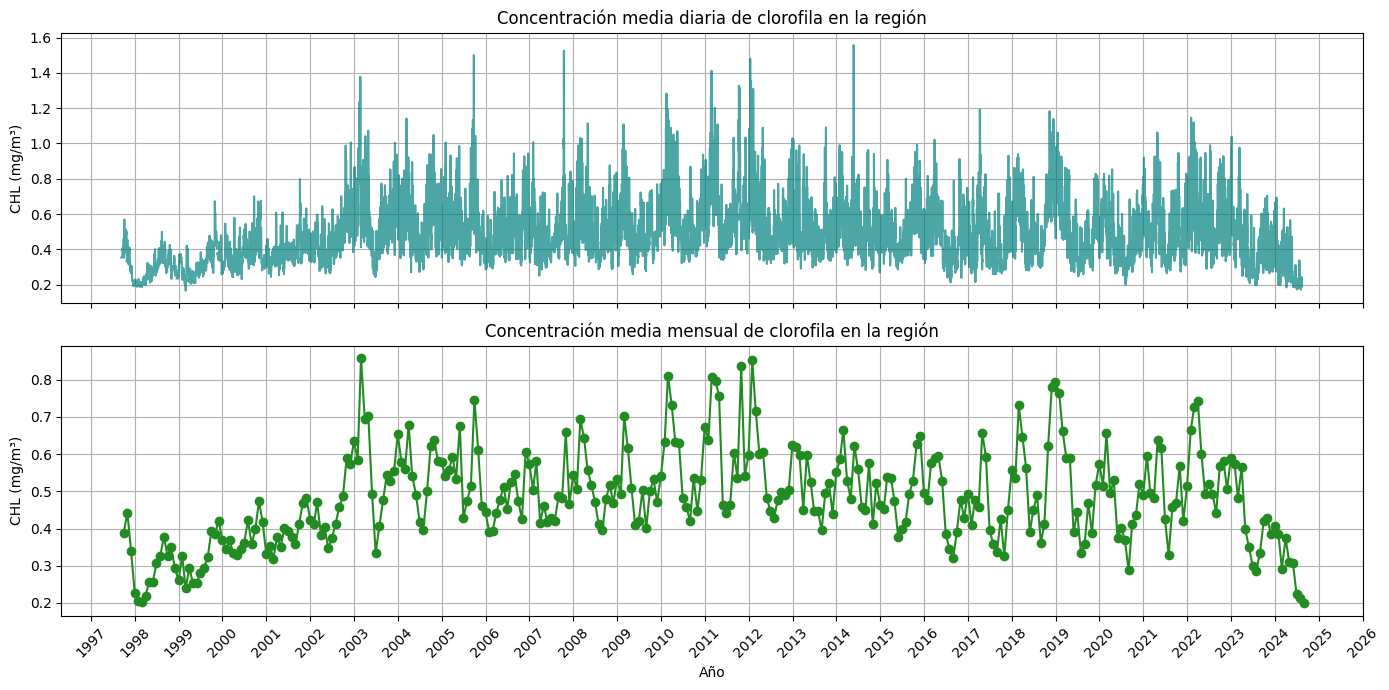

In [6]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 7), sharex=True)
ax1.plot(chl_media_diaria_df['time'], chl_media_diaria_df['CHL'], alpha=0.7, color='teal')
ax1.set_title("Concentración media diaria de clorofila en la región")
ax1.set_ylabel("CHL (mg/m³)")
ax1.grid(True)

ax2.plot(chl_media_mensual_df['time'], chl_media_mensual_df['CHL'],
         color='forestgreen', marker='o', linestyle='-')
ax2.set_title("Concentración media mensual de clorofila en la región")
ax2.set_xlabel("Año")
ax2.set_ylabel("CHL (mg/m³)")
ax2.grid(True)

ax2.xaxis.set_major_locator(mdates.YearLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

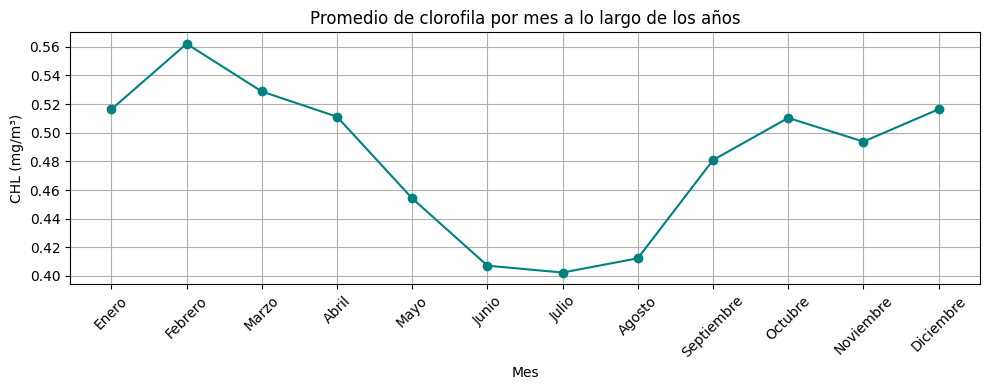

In [7]:
# Gráfica que indica la concentración promedio de CHL por mes por año

chl_media_mensual_df['Mes'] = chl_media_mensual_df['time'].dt.month
meses_nombre = {
    1: 'Enero', 2: 'Febrero', 3: 'Marzo', 4: 'Abril',
    5: 'Mayo', 6: 'Junio', 7: 'Julio', 8: 'Agosto',
    9: 'Septiembre', 10: 'Octubre', 11: 'Noviembre', 12: 'Diciembre'
}
chl_media_mensual_df['Mes_nombre'] = chl_media_mensual_df['Mes'].map(meses_nombre)
chl_mensual_folded = chl_media_mensual_df.groupby('Mes_nombre')['CHL'].mean()
orden_meses = list(meses_nombre.values())
plt.figure(figsize=(10, 4))
chl_mensual_folded = chl_mensual_folded.reindex(orden_meses)
chl_mensual_folded.plot(marker='o', color='teal')
plt.title("Promedio de clorofila por mes a lo largo de los años")
plt.xlabel("Mes")
plt.ylabel("CHL (mg/m³)")
plt.grid(True)
plt.xticks(ticks=range(12), labels=orden_meses, rotation=45)
plt.tight_layout()
plt.show()

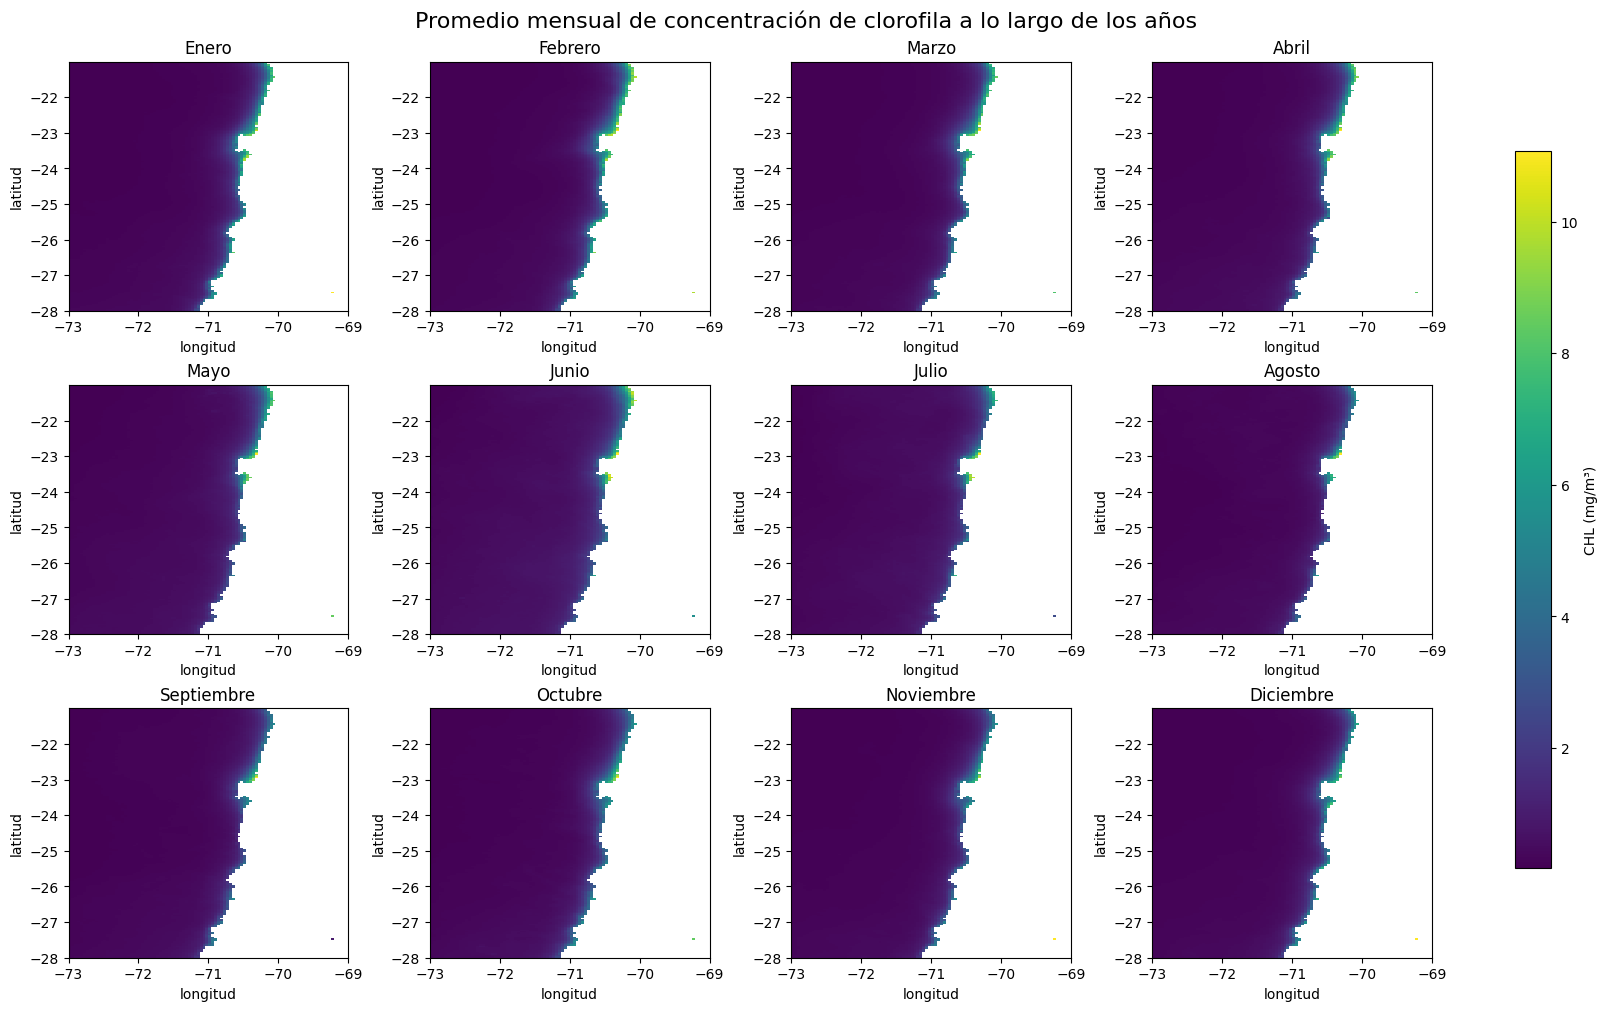

In [8]:
# Observación geográfica del promedio mensual de CHL

chl_clean = chl.where(chl > 0)
chl_mensual_promedio = chl_clean.groupby("time.month").mean(dim="time", skipna=True)
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10), constrained_layout=True)

for i, ax in enumerate(axes.flat):
    im = chl_mensual_promedio.sel(month=i+1).plot(
        ax=ax,
        cmap="viridis",
        add_colorbar=False
    )
    ax.set_title(f"{meses_nombre[i+1]}")
    ax.set_xlabel("longitud")
    ax.set_ylabel("latitud")
cbar = fig.colorbar(im, ax=axes, orientation='vertical', shrink=0.8, label="CHL (mg/m³)")
fig.suptitle("Promedio mensual de concentración de clorofila a lo largo de los años", fontsize=16)
plt.show()

Data variables:
    thetao   (time, depth, latitude, longitude) float32 13MB ...
Porcentaje de valores NaN: 36.58%


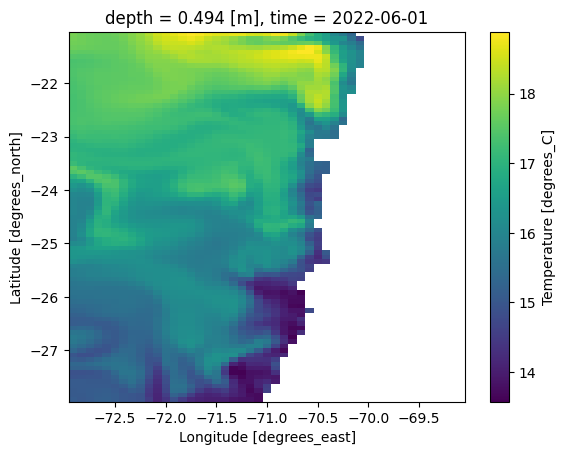

In [9]:
# Cargamos el segundo set de datos

ds2 = xr.open_dataset("drive/MyDrive/thetao_cmems_mod_glo_phy-thetao_anfc_0.083deg_P1D-m.nc")
lat_min, lat_max = -27.98, -21.02
lon_min, lon_max = -72.98, -69.02
ds2 = ds2.sel(
    latitude=slice(lat_min, lat_max),
    longitude=slice(lon_min, lon_max)
)
print(ds2.data_vars)

# Definimos la variable de temperatura superficial y la visualizamos

thetao = ds2['thetao']
num_nans = thetao.isnull().sum().item()
total_valores = thetao.size
porcentaje_nans = (num_nans / total_valores) * 100
print(f"Porcentaje de valores NaN: {porcentaje_nans:.2f}%")
thetao.isel(time=0).plot()

In [10]:
# Extraemos la temperatura superficial del mar (SST) y calculamos su promedio diario espacial

sst = thetao.sel(depth=0.494, method="nearest")
sst = thetao.isel(depth=0)
sst_media_diaria = sst.mean(dim=["latitude", "longitude"], skipna=True)
sst_media_diaria_df = sst_media_diaria.to_dataframe().reset_index()

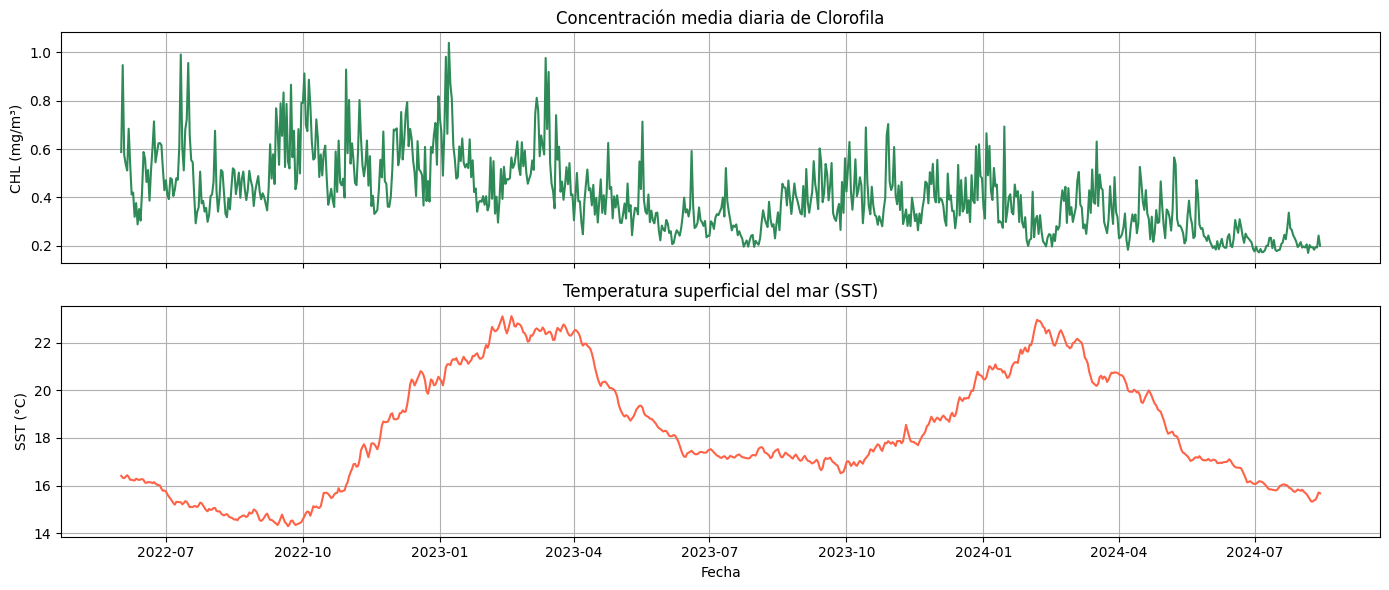

In [20]:
# En el mismo rango de tiempo, vemos la concentración de CHL y la temperatura superficial


df_comb = pd.merge(chl_media_diaria_df, sst_media_diaria_df, on='time', how='inner')
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14, 6), sharex=True)
ax1.plot(df_comb['time'], df_comb['CHL'], color='seagreen')
ax1.set_title("Concentración media diaria de Clorofila")
ax1.set_ylabel("CHL (mg/m³)")
ax1.grid(True)

ax2.plot(df_comb['time'], df_comb['thetao'], color='tomato')
ax2.set_title("Temperatura superficial del mar (SST)")
ax2.set_ylabel("SST (°C)")
ax2.set_xlabel("Fecha")
ax2.grid(True)
plt.tight_layout()
plt.show()

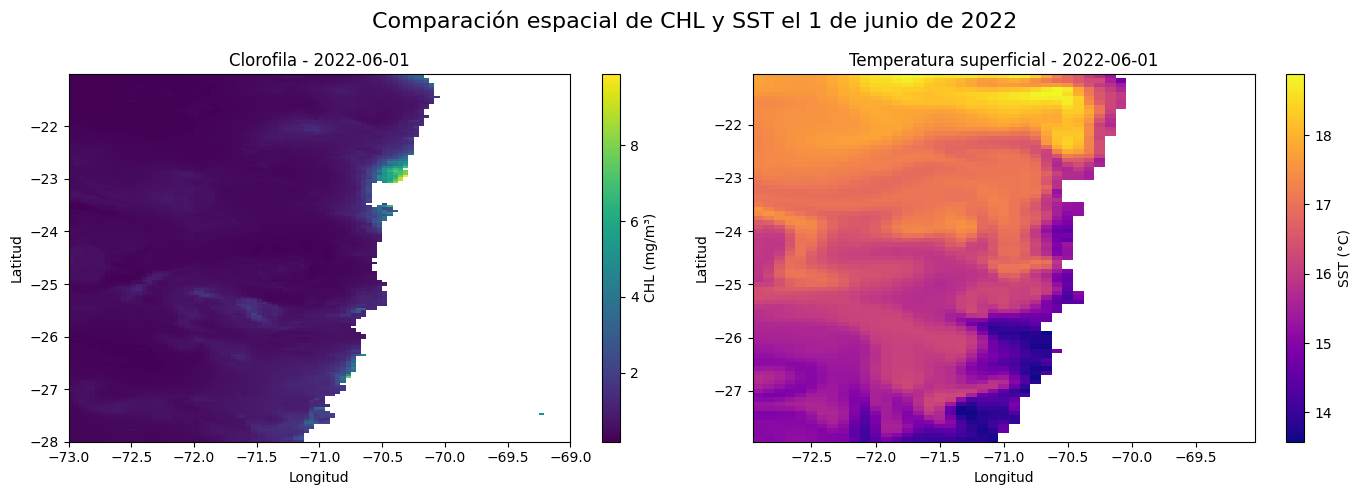

In [12]:
# Comparación en un instante de la concentración de CHL y la temperatura superficial.

fecha_objetivo = np.datetime64("2022-06-01")
chl_dia = chl.sel(time=fecha_objetivo, method="nearest")
sst_dia = ds2['thetao'].sel(time=fecha_objetivo, depth=0, method="nearest")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
im1 = chl_dia.plot(ax=ax1, cmap="viridis", add_colorbar=False)
ax1.set_title("Clorofila - 2022-06-01")
ax1.set_xlabel("Longitud")
ax1.set_ylabel("Latitud")

im2 = sst_dia.plot(ax=ax2, cmap="plasma", add_colorbar=False)
ax2.set_title("Temperatura superficial - 2022-06-01")
ax2.set_xlabel("Longitud")
ax2.set_ylabel("Latitud")
fig.colorbar(im1, ax=ax1, orientation='vertical', label="CHL (mg/m³)")
fig.colorbar(im2, ax=ax2, orientation='vertical', label="SST (°C)")

fig.suptitle("Comparación espacial de CHL y SST el 1 de junio de 2022", fontsize=16)
plt.tight_layout()
plt.show()

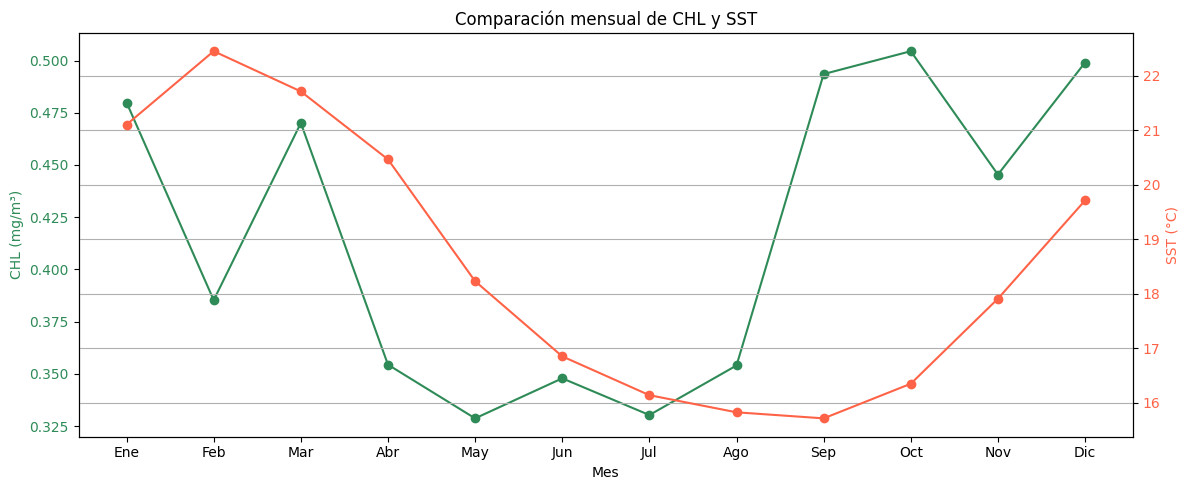

In [18]:
# Agrupación de CHL y SST por mes

chl_media_diaria_df['Mes'] = chl_media_diaria_df['time'].dt.month
sst_media_diaria_df['Mes'] = sst_media_diaria_df['time'].dt.month

chl_mensual = chl_media_diaria_df.groupby('Mes')['CHL'].mean()
sst_mensual = sst_media_diaria_df.groupby('Mes')['thetao'].mean()

meses = range(1, 13)
meses_nombre = {
    1: 'Enero', 2: 'Febrero', 3: 'Marzo', 4: 'Abril',
    5: 'Mayo', 6: 'Junio', 7: 'Julio', 8: 'Agosto',
    9: 'Septiembre', 10: 'Octubre', 11: 'Noviembre', 12: 'Diciembre'
}
labels_meses = [meses_nombre[m] for m in meses]

fig, ax1 = plt.subplots(figsize=(12, 5))

ax1.set_xlabel("Mes")
ax1.set_ylabel("CHL (mg/m³)", color='seagreen')
ax1.plot(chl_mensual.index, chl_mensual.values, color='seagreen', marker='o', label="CHL")
ax1.tick_params(axis='y', labelcolor='seagreen')
ax2 = ax1.twinx()

ax2.set_ylabel("SST (°C)", color='tomato')
ax2.plot(sst_mensual.index, sst_mensual.values, color='tomato', marker='o', label="SST")
ax2.tick_params(axis='y', labelcolor='tomato')
plt.title("Comparación mensual de CHL y SST")
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels([
    'Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun',
    'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'
])
plt.grid(True)
plt.tight_layout()
plt.show()

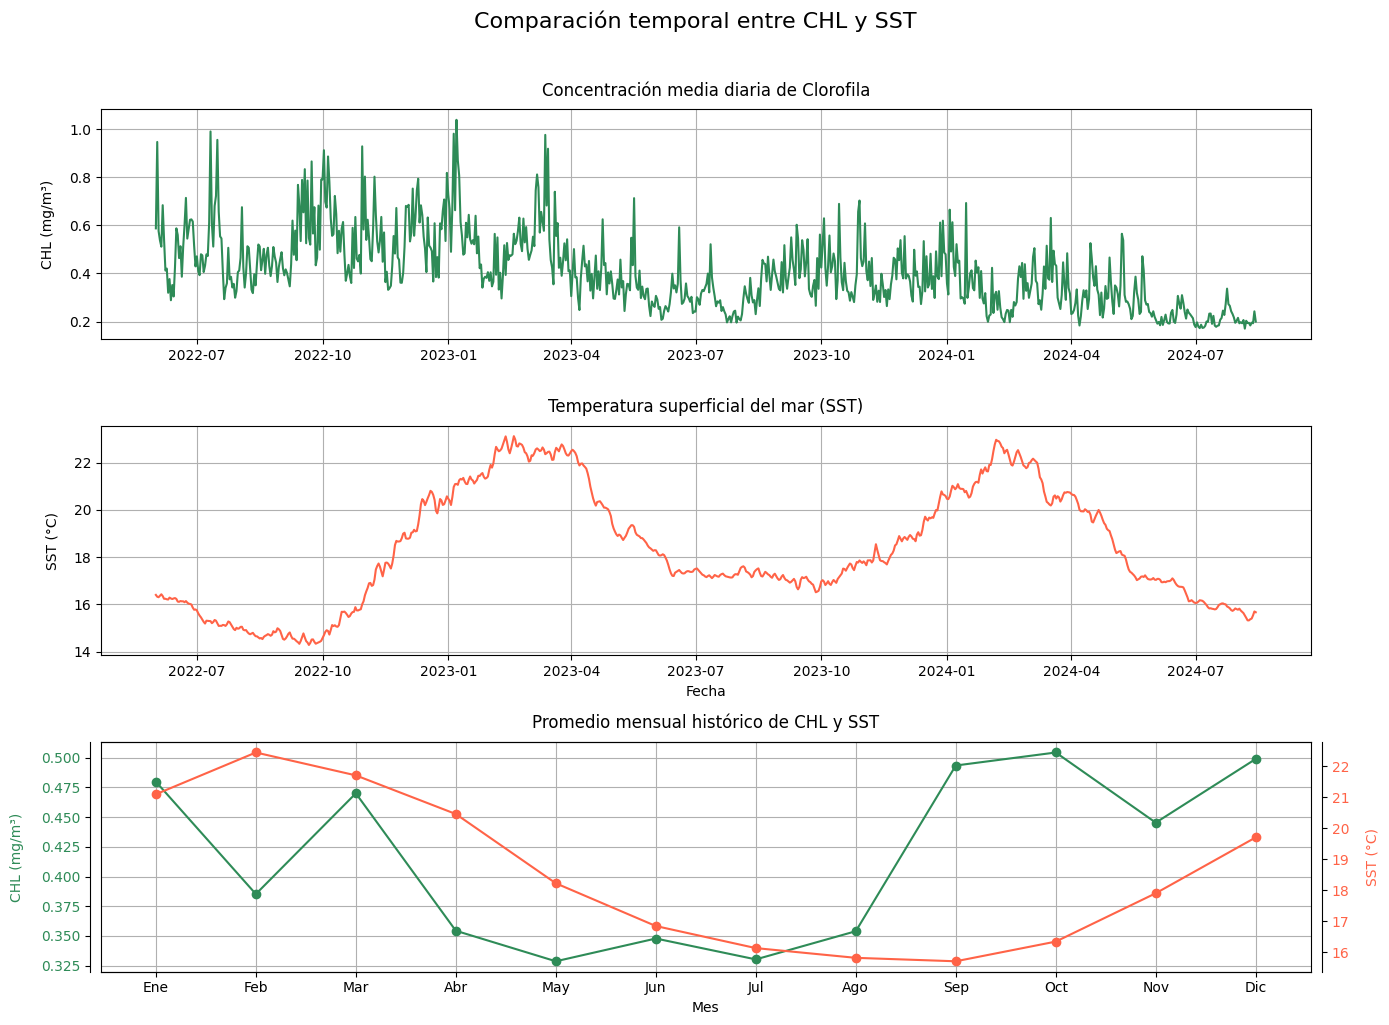

In [19]:
# Grafica en conjunto de la distribución diaria de SST y CHL junto con el comportamiento de ambas en meses.

fecha_limite = pd.to_datetime("2024-08-14")
df_comb = df_comb[df_comb['time'] <= fecha_limite]

fig = plt.figure(figsize=(14, 10))

ax1 = plt.subplot(3, 1, 1)
ax1.plot(df_comb['time'], df_comb['CHL'], color='seagreen')
ax1.set_title("Concentración media diaria de Clorofila", pad=10)
ax1.set_ylabel("CHL (mg/m³)", labelpad=10)
ax1.grid(True)

ax2 = plt.subplot(3, 1, 2, sharex=ax1)
ax2.plot(df_comb['time'], df_comb['thetao'], color='tomato')
ax2.set_title("Temperatura superficial del mar (SST)", pad=10)
ax2.set_ylabel("SST (°C)", labelpad=10)
ax2.set_xlabel("Fecha")
ax2.grid(True)

ax3 = plt.subplot(3, 1, 3)
ax3.set_title("Promedio mensual histórico de CHL y SST", pad=10)
ax3.set_xlabel("Mes")
ax3.set_ylabel("CHL (mg/m³)", color='seagreen', labelpad=12)
ax3.plot(chl_mensual.index, chl_mensual.values, color='seagreen', marker='o')
ax3.tick_params(axis='y', labelcolor='seagreen')
ax3.set_xticks(range(1, 13))
ax3.set_xticklabels([
    'Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun',
    'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'
])
ax3.grid(True)
ax4 = ax3.twinx()
ax4.set_ylabel("SST (°C)", color='tomato', labelpad=12)
ax4.plot(sst_mensual.index, sst_mensual.values, color='tomato', marker='o')
ax4.tick_params(axis='y', labelcolor='tomato')
ax3.spines['left'].set_position(('outward', 8))
ax4.spines['right'].set_position(('outward', 8))
plt.suptitle("Comparación temporal entre CHL y SST", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()